<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/1-vae/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Implementation

Adpated From: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

## Set up

In [64]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## Data

In [65]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])

In [66]:
trainset = torchvision.datasets.EuroSAT(root='./data',
                                            download=True, transform=transform)

In [67]:
trainset[0][0].shape

torch.Size([3, 64, 64])

In [68]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True)

In [69]:
print("[LOG] Total number of batches in the dataloader: %d" %len(trainloader))

[LOG] Total number of batches in the dataloader: 1688


### Plot images

In [70]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [71]:
classes = (
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
)

GroundTruth:  River River Highway PermanentCrop River PermanentCrop AnnualCrop Residential River HerbaceousVegetation Pasture River HerbaceousVegetation SeaLake PermanentCrop PermanentCrop


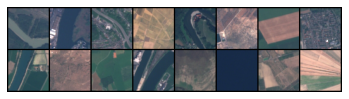

In [72]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

## Model

In [73]:
def create_model():
    #autoencoder = Autoencoder()
    autoencoder = VariationalAutoencoder()
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [74]:
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [75]:
def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

In [76]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Input size: [batch, 3, 64, 64]
#         # Output size: [batch, 3, 64, 64]
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 32, 32]
#             nn.ReLU(),
#             nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 16, 16]
#             nn.ReLU(),
# 			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 8, 8]
#             nn.ReLU(),
# # 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
# #             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
# #             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
# #             nn.ReLU(),
# 			        nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
#               nn.ReLU(),
# 		  	      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
#               nn.ReLU(),
#               nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
#               nn.Sigmoid(),
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [77]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [78]:
d = 10

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3*64*64, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 3*64*64),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, y):
        mu_logvar = self.encoder(y.view(-1, 3*64*64)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

In [79]:
parser = argparse.ArgumentParser(description="Train Autoencoder")
parser.add_argument("--valid", action="store_true", default=False,
                    help="Perform validation only.")

# Create model
autoencoder = create_model()

============== Encoder ==============
Sequential(
  (0): Linear(in_features=12288, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=20, bias=True)
)
============== Decoder ==============
Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=12288, bias=True)
  (3): Sigmoid()
)

Model moved to GPU in order to speed up training.


In [80]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in autoencoder.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 2473108.


In [81]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    autoencoder.parameters(),
    lr=learning_rate,
)

In [82]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(ỹ, y, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        ỹ, y.view(-1, 3*64*64), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [83]:
# Training and testing the VAE

epochs = 20
codes = dict(μ=list(), logσ2=list(), x=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        autoencoder.train()
        train_loss = 0
        for y, _ in trainloader:
            y = y.to(device)
            # ===================forward=====================
            ỹ, mu, logvar = autoencoder(y)
            loss = loss_function(ỹ, y, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(trainloader):.4f}')

====> Epoch: 1 Average loss: 123978.7907
====> Epoch: 2 Average loss: 122697.3863
====> Epoch: 3 Average loss: 122555.9725
====> Epoch: 4 Average loss: 122456.6421
====> Epoch: 5 Average loss: 122431.9408
====> Epoch: 6 Average loss: 122418.9895
====> Epoch: 7 Average loss: 122399.0940
====> Epoch: 8 Average loss: 122355.7582
====> Epoch: 9 Average loss: 122348.0139
====> Epoch: 10 Average loss: 122338.5043
====> Epoch: 11 Average loss: 122338.3143
====> Epoch: 12 Average loss: 122331.5645
====> Epoch: 13 Average loss: 122333.8030
====> Epoch: 14 Average loss: 122323.5935
====> Epoch: 15 Average loss: 122321.9473
====> Epoch: 16 Average loss: 122322.2834
====> Epoch: 17 Average loss: 122320.9880
====> Epoch: 18 Average loss: 122315.8486
====> Epoch: 19 Average loss: 122315.3072
====> Epoch: 20 Average loss: 122312.7540


In [84]:
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(autoencoder.state_dict(), "./weights/autoencoder.pkl")

Finished Training
Saving Model...


GroundTruth:  Highway River HerbaceousVegetation AnnualCrop River River Pasture Forest AnnualCrop Industrial Highway SeaLake Forest Industrial HerbaceousVegetation River


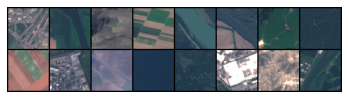

In [85]:
autoencoder.load_state_dict(torch.load("./weights/autoencoder.pkl"))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

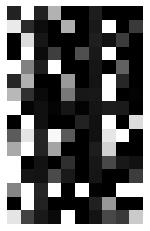

In [86]:
decoded_imgs = autoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))